# Data Processing

## Librairies imports

In [278]:
using Pkg;
Pkg.add("CSV");
Pkg.add("Random");
Pkg.add("DataStructures");
Pkg.add("BenchmarkTools");
Pkg.add("DataFrames");
Pkg.add("Statistics");
Pkg.add("Dates");
Pkg.add("Gadfly");
Pkg.add("MLBase");
Pkg.add("DecisionTree");
Pkg.add("GLM");

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Res

In [279]:
using CSV, DataFrames, GLM, Statistics, Dates, Gadfly, Random, MLBase;
include("utils/precipitation.jl");

## Build features

### 1. Ouvrages_surverse.csv

#### ID_ouvrage, Latitude, Longitude, Height

In [280]:
ouvrages = CSV.read("data/ouvrages-surverses.csv");
colnames = ["N_Env", "ID_SOMA", "ID_OUVRAGE", "NOM", "SOMA_SEC", "REGION", "TP_X", "TP_Y", "TP_Z", "TP_LAT", "TP_LNG", "EMI_X", "EMI_Y", "EMI_LNG", "EMI_LAT"];
names!(ouvrages, Symbol.(colnames));
select!(ouvrages, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z]);

#### Replace missing Z index with mean

In [281]:
ouvrages.TP_Z = coalesce.(ouvrages.TP_Z, mean(ouvrages[completecases(ouvrages), :].TP_Z));
first(shuffleDf(ouvrages), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z
,String,Float64,Float64,Float64
1,4270-01D,45.6105,-73.5087,11.17
2,4230-05D,45.6728,-73.4915,11.55
3,4770-01D,45.6574,-73.4902,10.77
4,4560-01D,45.4509,-73.7843,26.37
5,3540-02D,45.4751,-73.8727,26.52


#### Visualtion des données chargées

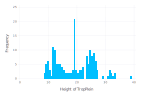

In [282]:
plot(ouvrages, x=:TP_Z, Geom.histogram(bincount=50), Guide.xlabel("Height of TropPlein"),Guide.ylabel("Frequency"))

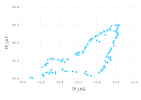

In [283]:
plot(ouvrages,x=:TP_LNG, y=:TP_LAT, Geom.point)

### 2. Surverses.csv

#### NO_ouvrage, Date, Surverse

In [284]:
surverses = CSV.read("data/surverses.csv", missingstring="-99999");

first(shuffleDf(surverses),5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,4620-04D,2016-12-29,0,missing
2,3450-01D,2013-09-14,0,missing
3,3560-01D,2014-06-28,0,missing
4,4420-04D,2017-03-14,missing,P
5,3250-01D,2018-01-08,0,missing


#### Filter months

In [285]:
surverses = filter(row -> month(row.DATE) > 4, surverses);
surverses = filter(row -> month(row.DATE) < 11, surverses);

#### Filter non rain surverses

In [286]:
raison = coalesce.(surverses[:,:RAISON],"Inconnue");
surverses[!,:RAISON] = raison;

surverses = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], surverses);
select!(surverses, [:NO_OUVRAGE, :DATE, :SURVERSE]);

#### Remove missing data and rename

In [287]:
surverses = dropmissing(surverses, disallowmissing=true);
rename!(surverses, :NO_OUVRAGE => :ID_OUVRAGE);
first(shuffleDf(surverses), 5)

,ID_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,4350-01D,2015-10-06,0
2,3305-04D,2018-08-16,0
3,3230-01D,2016-06-03,0
4,4280-01D,2013-09-17,0
5,4620-01D,2015-08-02,0


### 3. Precipitation.csv

#### Date, Heure, McTavish, Bellevue, Assomption, Trudeau, StHubert

#### Load and filter months between May & October included

In [288]:
precipitations = CSV.read("data/precipitations.csv",missingstring="-99999");
rename!(precipitations, Symbol("St-Hubert")=>:StHubert);

precipitations = filter(row -> month(row.date) > 4, precipitations);
precipitations = filter(row -> month(row.date) < 11, precipitations); 

In [289]:
first(shuffleDf(precipitations),5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2015-06-27,23,0,0,0,0,0
2,2016-05-30,19,0,0,0,0,0
3,2015-09-04,14,0,0,0,0,0
4,2018-06-18,22,0,0,0,0,2
5,2019-05-14,6,3,7,11,7,2


#### Replace missing data by 0

In [290]:
#OLD WAY

#precipitation[!,:McTavish] = coalesce.(precipitation[:,:McTavish], 0);
#precipitation[!,:Bellevue] = coalesce.(precipitation[:,:Bellevue], 0);
#precipitation[!,:Assomption] = coalesce.(precipitation[:,:Assomption], 0);
#precipitation[!,:Trudeau] = coalesce.(precipitation[:,:Trudeau], 0);
#precipitation[!,:StHubert] = coalesce.(precipitation[:,:StHubert], 0);

#first(shuffleDf(precipitation), 5)

In [291]:
precipitation_by_day = by(precipitations, :date,  
                            McTavish = :McTavish=>mean_wo_missing, 
                            Bellevue = :Bellevue=>mean_wo_missing, 
                            Assomption = :Assomption=>mean_wo_missing,
                            Trudeau = :Trudeau=>mean_wo_missing,
                            StHubert = :StHubert=>mean_wo_missing)

for i=1:size(precipitations,1)
    if isequal(precipitations[i, :McTavish], missing)
        precipitations[i,:McTavish] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:McTavish][1]
    end
    if isequal(precipitations[i, :Bellevue], missing)
        precipitations[i,:Bellevue] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Bellevue][1]
    end
    if isequal(precipitations[i, :Assomption], missing)
        precipitations[i,:Assomption] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Assomption][1]
    end
    if isequal(precipitations[i, :Trudeau], missing)
        precipitations[i,:Trudeau] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Trudeau][1]
    end
    if isequal(precipitations[i, :StHubert], missing)
        precipitations[i,:StHubert] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:StHubert][1]
    end
end

first(shuffleDf(precipitations), 5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2019-09-20,7,0,0,0,0,0
2,2018-10-28,6,8,7,2,5,5
3,2015-09-29,21,13,12,0,14,18
4,2018-06-26,11,0,0,0,0,0
5,2018-10-27,11,0,0,0,0,0


###  Precipitation aggregation

#### Sum of precipitation for the day

In [292]:
pcp_sum = by(precipitations, :date,  
            McTavish = :McTavish=>sum, 
            Bellevue = :Bellevue=>sum,
            Assomption = :Assomption=>sum, 
            Trudeau = :Trudeau=>sum, 
            StHubert = :StHubert=>sum);
first(shuffleDf(pcp_sum), 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2019-05-12,0,0,0,0,0
2,2019-10-23,152,0,0,114,149
3,2019-06-07,0,0,0,0,0
4,2017-06-06,192,138,90,124,85
5,2015-09-17,0,0,0,0,0


#### Representation visuelle des données enregistrées des différentes stations. 
(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

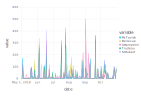

In [293]:
df_for_plot = pcp_sum
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)

plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Maximum precipitation in an hour for the day

In [294]:
pcp_max = by(precipitations, :date,  
            McTavish = :McTavish=>maximum,
            Bellevue = :Bellevue=>maximum, 
            Assomption = :Assomption=>maximum,
            Trudeau = :Trudeau=>maximum,
            StHubert = :StHubert=>maximum)
first(shuffleDf(pcp_max),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2017-06-12,0,0,0,20,53
2,2019-08-31,0,0,0,0,0
3,2014-08-29,0,0,0,0,0
4,2019-06-25,65,0,41,59,28
5,2017-09-08,0,0,0,3,0


#### Representation visuelle des données enregistrées des différentes stations

(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

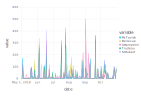

In [295]:
df_for_plot = pcp_max
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Maximum precipitation during three consecutive hours in a day

In [296]:
pcp_max3h = by(precipitations, :date,
                McTavish = :McTavish=>maximum3,
                Bellevue = :Bellevue=>maximum3,
                Assomption = :Assomption=>maximum3,
                Trudeau = :Trudeau=>maximum3,
                StHubert = :StHubert=>maximum3)
first(shuffleDf(pcp_max3h),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2016-10-18,26,35,40,32,32
2,2018-07-30,0,0,10,0,0
3,2017-05-18,5,3,10,2,0
4,2014-09-29,0,0,0,0,0
5,2016-08-16,593,393,432,500,466


#### Representation visuelle des données enregistrées des différentes stations

(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

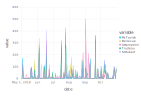

In [297]:
df_for_plot = pcp_max3h
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Visualisation of all three agregations for 1 meteo station

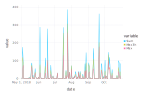

In [298]:
mct_sum = pcp_sum[:,[1,2]]
rename!(mct_sum,:McTavish => :Sum);
mct_sum = filter(row -> year(row.date) == 2018, mct_sum);

mct_max = pcp_max[:,[1,2]]
rename!(mct_max,:McTavish => :Max);
mct_max = filter(row -> year(row.date) == 2018, mct_max);

mct_max3h = pcp_max3h[:,[1,2]]
rename!(mct_max3h,:McTavish => :Max3h);
mct_max3h = filter(row -> year(row.date) == 2018, mct_max3h);

df_for_plot = join(mct_sum, mct_max3h, on = :date);
df_for_plot = join(df_for_plot, mct_max, on = :date);
df_for_plot = melt(df_for_plot, :date)


plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

### Join Dataframes

In [299]:
X_test = CSV.read("data/test.csv");
rename!(X_test, :NO_OUVRAGE => :ID_OUVRAGE);

In [300]:
X_test = join(ouvrages, X_test, on =:ID_OUVRAGE);
features = join(ouvrages, surverses, on =:ID_OUVRAGE);
first(shuffleDf(features), 10)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,SURVERSE
,String,Float64,Float64,Float64,Date,Int64
1,3782-01D,45.4721,-73.8778,24.14,2016-09-10,0
2,4430-02D,45.4344,-73.5869,18.56,2015-08-12,0
3,4300-01D,45.5707,-73.5207,13.59,2017-08-01,0
4,4720-01D,45.7001,-73.4891,10.6,2013-09-16,0
5,3250-02D,45.6437,-73.5541,38.93,2018-09-21,0
6,4360-01D,45.4907,-73.5508,15.15,2013-05-24,0
7,3750-01D,45.6087,-73.6397,11.6,2015-06-02,0
8,4795-01D,45.4499,-73.5682,15.747,2016-08-13,0
9,0801-04D,45.5029,-73.5238,12.36,2015-06-28,0


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[301]:2
└ @ Core In[301]:2
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[301]:2
└ @ Core In[301]:2


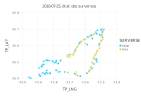

In [301]:
df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:SURVERSE, Guide.title("2018-07-25, état des surverses"))
#first(df_for_geo_plot,5) 

### Add precipitation data to features

#### Get stations lat-lng

In [302]:
station_df = DataFrame(STATION = String[], LAT = Float64[], LNG = Float64[]);

push!(station_df, ["McTavish", 45.504742, -73.579167]);
push!(station_df, ["Bellevue", 45.427222, -73.929167]);
push!(station_df, ["Assomption", 45.809444, -73.434722]);
push!(station_df, ["Trudeau", 45.467778, -73.741667]);
push!(station_df, ["StHubert", 45.5175, -73.416944]);

station_df

,STATION,LAT,LNG
,String,Float64,Float64
1,McTavish,45.5047,-73.5792
2,Bellevue,45.4272,-73.9292
3,Assomption,45.8094,-73.4347
4,Trudeau,45.4678,-73.7417
5,StHubert,45.5175,-73.4169


### Augment Features

#### Add pcp_sum, pcp_max, pcp_max3 columns

In [303]:
function addColsForPrecipationPerDay(df)
    df[!, :PCP_SUM] = zeros(size(df, 1));
    df[!, :PCP_MAX] = zeros(size(df, 1));
    df[!, :PCP_MAX3] = zeros(size(df, 1));
    df[!, :METEO] = fill("", size(df, 1));
    return df
end

X_test = addColsForPrecipationPerDay(X_test)
permutecols!(X_test, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z, :DATE, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3]);
    
features = addColsForPrecipationPerDay(features)

first(features, 5)

ArgumentError: ArgumentError: column name :SURVERSE not found in the data frame

In [ ]:
first(shuffleDf(features), 10)

#### Find closest station to each ouvrage and add pcp_sum and pcp_max to it

In [ ]:
for i=1:size(features, 1)
    id_ouvrage = features[i, 1]; 
    closest_station = "McTavish"; # initial value
    shortest_dist = -1;
    
    # Find closest station
    for j=1:size(station_df, 1)
        dist = findDistance(features[i, :TP_LAT], features[i, :TP_LNG], station_df[j, :LAT], station_df[j, :LNG]);
        
        if shortest_dist == -1 || dist < shortest_dist
            shortest_dist = dist;
            closest_station = station_df[j, :STATION];
        end
    end
    
    # Augment comb with a weighted p_sum, based on the distance to the station
    p_sum = pcp_sum[∈([features[i, :DATE]]).(pcp_sum.date), Symbol(closest_station)];
#     comb[i, :PCP_SUM] = p_sum[1] * (1 - shortest_dist);
    features[i, :PCP_SUM] = p_sum[1]; 
    
    # Augment comb with a weighted p_max, based on the distance to the station
    p_max = pcp_max[∈([features[i, :DATE]]).(pcp_max.date), Symbol(closest_station)]
#     comb[i, :PCP_MAX] = p_max[1] * (1 - shortest_dist);
    features[i, :PCP_MAX] = p_max[1];
    
    # Augment comb with a weighted p_max3h, based on the distance to the station
    p_max3 = pcp_max3h[∈([features[i, :DATE]]).(pcp_max3h.date), Symbol(closest_station)]
#     comb[i, :PCP_MAX3] = p_max3[1] * (1 - shortest_dist);
    features[i, :PCP_MAX3] = p_max3[1]; 
    
    features[i, :METEO] = closest_station
end

#### Remove outlier in PCP_SUM and PCP_MAX AND PCP_MAX3 that cause compression

In [ ]:
features[features[:PCP_SUM] .> 750, :PCP_SUM] = 750;
features[features[:PCP_MAX] .> 500, :PCP_MAX] = 500;
features[features[:PCP_MAX3] .> 750, :PCP_MAX3] = 750;

# first(shuffleDf(filter(row -> row.SURVERSE == 1, features)), 5)

#### TP location colored by their affiliation to its closest meteo station

In [ ]:
df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:METEO, Guide.title("2018-07-25, Regroupement par station météo"))
#first(df_for_geo_plot,5) 

#### Ouvrage 3350-07D for 2018, when it overflow and quantity based on max3h rain fallen.

In [ ]:

# 3260-01D dans Rivière-des-Prairies
# 3350-07D dans Ahunstic
# 4240-01D dans Pointe-aux-Trembles
# 4350-01D dans le Vieux-Montréal
# 4380-01D dans Verdun

id_ouvrage_to_show = "3350-07D"
df_temp = filter(row -> row.ID_OUVRAGE ∈ [id_ouvrage_to_show], features)
df_temp = filter(row -> year(row.DATE) == 2018, df_temp);
df_temp = df_temp[!,[:ID_OUVRAGE, :DATE, :PCP_MAX3, :SURVERSE]]
df_temp[:SURVERSE] = convert(Array{Bool,1}, df_temp[:SURVERSE])



plot(df_temp, x=:DATE, y=:PCP_MAX3, Geom.point, color=:SURVERSE,Guide.title(id_ouvrage_to_show))
#first(shuffleDf(df_temp), 10)

### Split dates into months and days

In [ ]:
features.MONTH = month.(features.DATE);
features.DAY = day.(features.DATE);
first(shuffleDf(features[!, [:DATE, :MONTH, :DAY]]), 5)

## Split Dataframes into train, validation and test

In [ ]:
function partitionTrainTest(data, at = 0.8) # https://discourse.julialang.org/t/simple-tool-for-train-test-split/473/2
    n = nrow(data)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return data[train_idx,:], data[test_idx,:]
end


In [ ]:
function standarizeTrainTestCol(X_train, col, X_test=missing)
    mean_train_col = mean(X_train[!, col]);
    std_train_col = std(X_train[!, col]);
    X_train[!, col] = (X_train[!, col] .- mean_train_col) ./ std_train_col;
    if !isequal(X_test, missing)
        X_test[!, col] = (X_test[!, col] .- mean_train_col) ./ std_train_col;
    end
    return X_train, X_test
end
    

####  Standardize the PCP and Date before splitting into X_train and X_val

In [ ]:
X_train = filter(row-> year(row.DATE) .< 2019, features)
 

#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_SUM)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX3)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :MONTH)
#X_train, X_test = standarizeTrainTestCol(X_train, X_test, :DAY)

X_train, X_val = partitionTrainTest(X_train, 0.8)

first(shuffleDf(X_train),5)

In [ ]:
first(shuffleDf(X_test),5)

In [ ]:
first(shuffleDf(X_val),5)

###  Standardize the PCP and Date

In [ ]:
# mean_pcpsum = mean(features.PCP_SUM);
# std_pcpsum = std(features.PCP_SUM);
# features.PCP_SUM = (features.PCP_SUM .- mean_pcpsum) ./ std_pcpsum;

# mean_pcpmax = mean(features.PCP_MAX);
# std_pcpmax = std(features.PCP_MAX);
# features.PCP_MAX = (features.PCP_MAX .- mean_pcpmax) ./ std_pcpmax;

# mean_pcpmax3 = mean(features.PCP_MAX3);
# std_pcpmax3 = std(features.PCP_MAX3);
# features.PCP_MAX3 = (features.PCP_MAX3 .- mean_pcpmax3) ./ std_pcpmax3;

# meanmonth = mean(features.MONTH);
# stdmonth = std(features.MONTH);
# features.MONTH = (features.MONTH .- meanmonth) ./ stdmonth;

# meanday = mean(features.DAY);
# stdday = std(features.DAY);
# features.DAY = (features.DAY .- meanday) ./ stdday;

In [ ]:
first(shuffleDf(filter(row -> row.SURVERSE == 1, features)), 5)